In [165]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, BatchNormalization, Input,
                                     Conv2D, GlobalAveragePooling2D, LeakyReLU)
from matplotlib import pyplot as plt

Define helper functions.

In [138]:
def l1_norm(inputs):
    u, v = inputs
    difference = u - v
    return GlobalAveragePooling2D()(difference)

In [30]:
def contrastive_loss(y, d):
    margin = 1.
    y = tf.cast(y, dtype=tf.float32)
    return tf.reduce_mean(y * tf.square(d) + (1 - y) * tf.square(tf.maximum(margin - d, 0)))

In [234]:
def create_pairs(x, digit_indices, digits):
    """Positive and negative pair creation.
    
    Alternates between positive and negative pairs.
    
    """
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in digits]) - 1
    for d in digits:
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, len(digits))
            dn = digits[inc]
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [71]:
def compute_accuracy(predictions, labels):
    """ Compute classification accuracy with a fixed threshold on distances.
    """
    pred_1 = tf.cast(predictions < 0.5, dtype=tf.int32)
    labels = tf.cast(labels, dtype=tf.int32)
    return tf.metrics.categorical_accuracy(labels, pred_1)

Load and pre-process the data.

In [93]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train = X_train.reshape(60000, 784)
# X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train /= 255
X_test /= 255
in_dim = X_train.shape[-3:]
nb_epoch = 20

Plot some of the image pool.

In [274]:
num_row = 2
num_col = 5

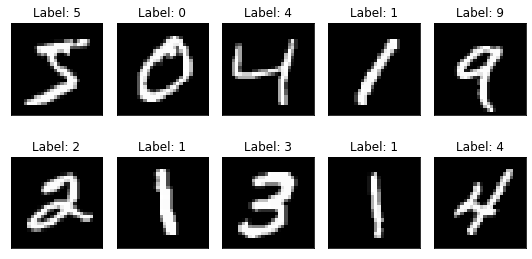

In [275]:
fig, axes = plt.subplots(num_row, num_col,
                         figsize=(1.5*num_col, 2*num_row))
for i in range(num_row * num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_train[i, ..., 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('Label: {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

Create training and testing positive and negative pairs.

In [255]:
digit_indices = np.array([np.where(y_train == i)[0] for i in range(10)])
digits = [0, 2, 3, 4, 5, 6, 7]
tr_pairs, tr_y = create_pairs(X_train, digit_indices, digits)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
digits = [1, 8, 9]
te_pairs, te_y = create_pairs(X_test, digit_indices, digits)

Plot some examples of pairs.

In [203]:
num_pairs = 10

Training pairs


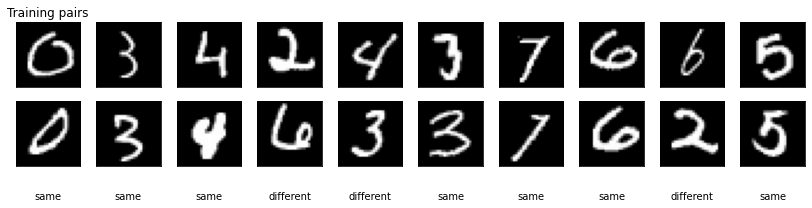

In [270]:
fig, axes = plt.subplots(2, num_pairs,
                         figsize=(2*num_pairs, 3))
for i in range(num_pairs):
    im = random.randint(0, len(tr_pairs))
    ax = axes[0, i]
    ax.imshow(tr_pairs[im][0, ..., 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = axes[1, i]
    ax.imshow(tr_pairs[im][1, ..., 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('same' if tr_y[im] == 1 else 'different',
                  rotation=0, labelpad=25)
axes[0, 0].set_title('Training pairs')
plt.tight_layout(w_pad=-60)
plt.show()

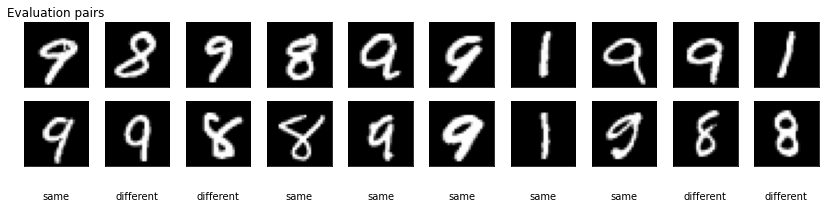

In [271]:
fig, axes = plt.subplots(2, num_pairs,
                         figsize=(2*num_pairs, 3))
for i in range(num_pairs):
    im = random.randint(0, len(te_pairs))
    ax = axes[0, i]
    ax.imshow(te_pairs[im][0, ..., 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = axes[1, i]
    ax.imshow(te_pairs[im][1, ..., 0], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('same' if te_y[im] == 1 else 'different',
                  rotation=0, labelpad=25)
axes[0, 0].set_title('Evaluation pairs')
plt.tight_layout(w_pad=-60)
plt.show()

Define the network.

In [157]:
def create_base_net(input_dim):
    x_in = Input(shape=input_dim)
    x = BatchNormalization()(x_in)
    x = Conv2D(8, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(x)
    x_1 = x + x_in
    x = BatchNormalization()(x_1)
    x = Conv2D(8, kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(x)
    x_2 = x + x_1
    x = BatchNormalization()(x_2)
    x = Conv2D(input_dim[-1], kernel_size=(3, 3), padding='same')(x)
    x = LeakyReLU()(x)
    x_3 = x + x_2
#     x = GlobalAveragePooling2D()(x_3)
    return Model(inputs=x_in, outputs=x_3)

Create the base model that is shared by both inputs.

In [258]:
base_model = create_base_net(in_dim)

Create inputs for each side of the network.

In [259]:
input_a = Input(shape=in_dim)
input_b = Input(shape=in_dim)

Pass each input through the *same* base model.

In [260]:
output_a = base_model(input_a)
output_b = base_model(input_b)

Calculate a distance measure between the encoded inputs.

In [261]:
distance = l1_norm([output_a, output_b])

Compile the model so that it accepts two inputs and returns a distance measure between them.

In [262]:
model = Model(inputs=[input_a, input_b], outputs=distance)

In [263]:
model.compile(loss=contrastive_loss, optimizer='adam', metrics=[compute_accuracy])

Train the model on our data and test.

In [264]:
model.fit(x=[tr_pairs[:, 0], tr_pairs[:, 1]],
          y=tr_y,
          batch_size=128,
          epochs=1,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

Train on 75880 samples, validate on 5838 samples
75880/75880 [==============================] - 52s 683us/sample - loss: 0.4832 - compute_accuracy: 1.0000 - val_loss: 0.5230 - val_compute_accuracy: 1.0000
